### PREDICTING CREDIT RISK FOR LOAN APPLICANTS

### 1. Objective
Develop a machine learning model to predict the credit risk of loan applicants using the German Credit dataset. The model should classify applicants into two categories: good credit risk and bad credit risk. Additionally, provide insights into the key factors influencing credit risk and suggest strategies for improving the credit evaluation process.

### 2. Data Exploration and Preprocessing

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('german_credit_data.csv')

In [135]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.fillna({'Saving accounts': 'moderate', 'Checking account': 'moderate'})
# Total amount of credit requested
df['Total credit']= df['Credit amount']*df['Duration']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Total credit      1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


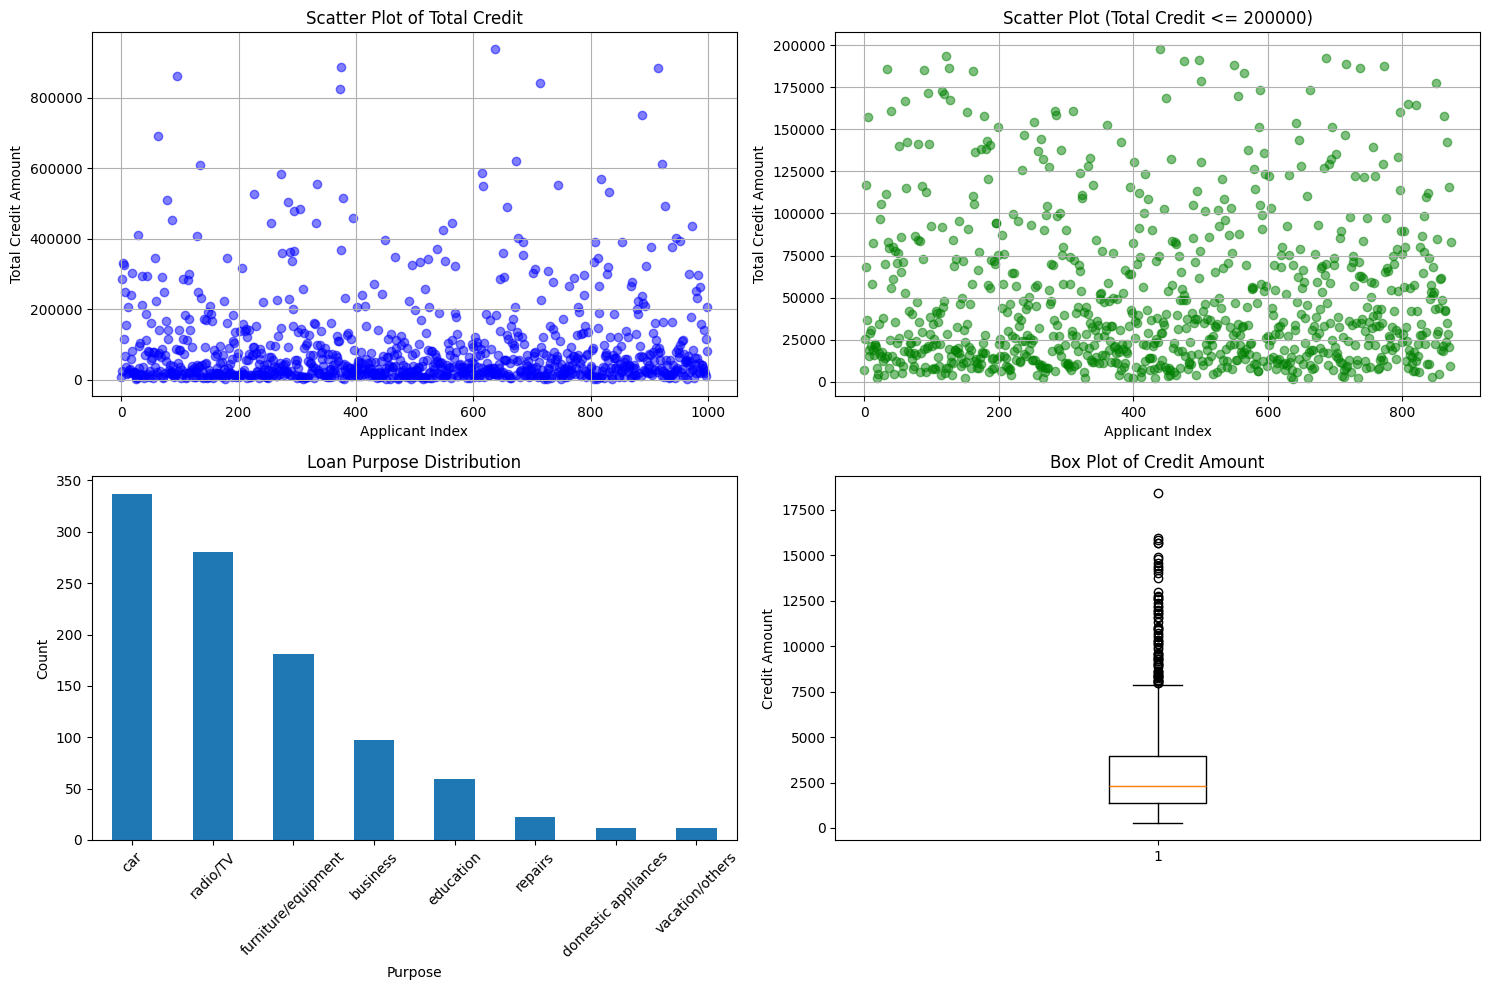

In [137]:
# Set up a single figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot - (Top Left)
axs[0, 0].scatter(range(len(df)), df['Total credit'], color='blue', alpha=0.5)
axs[0, 0].set_title('Scatter Plot of Total Credit')
axs[0, 0].set_xlabel('Applicant Index')
axs[0, 0].set_ylabel('Total Credit Amount')
axs[0, 0].grid(True)

# Scatter plot (Total credit up to 200000) - (Top Right)
filtered_df = df[df['Total credit'] <= 200000]
axs[0, 1].scatter(range(len(filtered_df)), filtered_df['Total credit'], color='green', alpha=0.5)
axs[0, 1].set_title('Scatter Plot (Total Credit <= 200000)')
axs[0, 1].set_xlabel('Applicant Index')
axs[0, 1].set_ylabel('Total Credit Amount')
axs[0, 1].grid(True)

# Purpose counts - (Bottom Left)
df['Purpose'].value_counts().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Loan Purpose Distribution')
axs[1, 0].set_xlabel('Purpose')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)

# Credit Amount box plot - (Bottom Right)
axs[1, 1].boxplot(df['Credit amount'])
axs[1, 1].set_title('Box Plot of Credit Amount')
axs[1, 1].set_ylabel('Credit Amount')

# Adjust layout
plt.tight_layout()
plt.show()

In [138]:
# Create target variable - we'll assume credit risk based on credit amount and duration
# Higher credit amount and longer duration are considered higher risk
# Saving account and Checking account are import parameters to evaluate risk.
# So, will consider these factors to label for risk prediction
df['CreditRisk'] = 0

# Total amount of credit requested
df['Total credit']= df['Credit amount']*df['Duration']

# depending upon saving and checking account amount we will decide the safe threshold amount of total credit.
condition = (((df['Saving accounts'] == 'rich') & (df['Checking account'] == 'rich')) |((df['Saving accounts'] == 'quite rich') & (df['Checking account'] == 'rich')) | ((df['Saving accounts'] == 'quite rich') & (df['Checking account'] == 'moderate')))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > (5 * df['Total credit'].median()),1,0
)
condition = (((df['Saving accounts'] == 'rich') & (df['Checking account'] == 'moderate'))|((df['Saving accounts'] == 'moderate') & (df['Checking account'] == 'rich')) | ((df['Saving accounts'] == 'quite rich') & (df['Checking account'] == 'little')))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > (3.5 * df['Total credit'].median()),1,0
)
condition = (((df['Saving accounts'] == 'rich') & (df['Checking account'] == 'little'))|((df['Saving accounts'] == 'little') & (df['Checking account'] == 'rich')))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > (2 * df['Total credit'].median()),1,0
)
condition = ((df['Saving accounts'] == 'moderate') & (df['Checking account'] == 'moderate'))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > (df['Total credit'].median()),1,0
)
condition = (((df['Saving accounts'] == 'moderate') & (df['Checking account'] == 'little'))|((df['Saving accounts'] == 'little') & (df['Checking account'] == 'moderate')))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > ((3/4) * df['Total credit'].median()),1,0
)
condition = ((df['Saving accounts'] == 'little') & (df['Checking account'] == 'little'))
df.loc[condition, 'CreditRisk'] = np.where(
    df.loc[condition, 'Total credit'] > (0.5*df['Total credit'].median()),1,0
)

df.drop(columns=['Total credit'], inplace=True)
df.drop(columns=['Age','Sex','Job','Housing','Purpose'], inplace=True)

In [139]:
df.head()

,Saving accounts,Checking account,Credit amount,Duration,CreditRisk
0,moderate,little,1169,6,0
1,little,moderate,5951,48,1
2,little,moderate,2096,12,0
3,little,little,7882,42,1
4,little,little,4870,24,1


### 3. Model Development

In [140]:
##Feature Encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate features and target
X = df.drop('CreditRisk', axis=1)
y = df['CreditRisk']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-hot encode categorical features
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')  # Keep the rest of the columns as they are

# Transform features
X_encoded = ct.fit_transform(X)

# View encoded feature names
feature_names = ct.get_feature_names_out()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (800, 7)
Test set shape: (200, 7)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        95
           1       0.98      0.96      0.97       105

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        95
           1       0.97      0.97      0.97       105

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      0.98      0.99       105

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
we

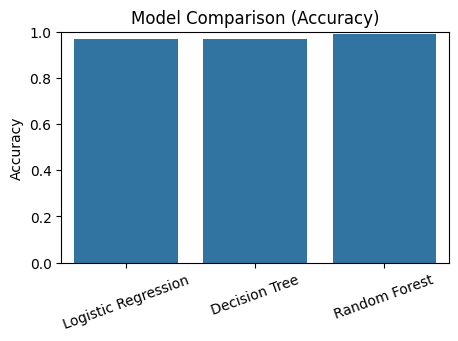

In [141]:
# Model Training and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Train and evaluate
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred))
    results[model_name] = {
        'Accuracy': model.score(X_test, y_test),
        'Model': model
    }

# Compare model performance
accuracy_scores = {k: v['Accuracy'] for k, v in results.items()}
plt.figure(figsize=(5, 3))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()))
plt.xticks(rotation=20)
plt.ylabel('Accuracy')
plt.title('Model Comparison (Accuracy)')
plt.ylim(0, 1)
plt.show()


### 4. Optimization of model

Cross-Validation

--- Logistic Regression Cross-Validation ---
Mean Accuracy: 0.9520
Standard Deviation: 0.0136

--- Decision Tree Cross-Validation ---
Mean Accuracy: 0.9600
Standard Deviation: 0.0110

--- Random Forest Cross-Validation ---
Mean Accuracy: 0.9810
Standard Deviation: 0.0124



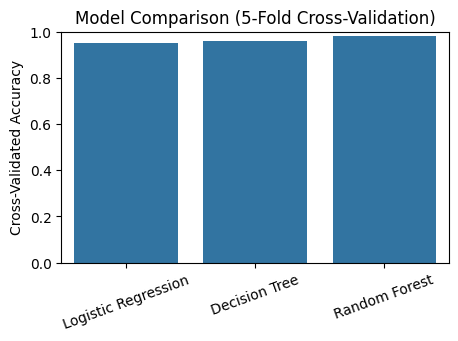

In [142]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross-Validation
cv_results = {}

for model_name, model_info in results.items():
    model = model_info['Model']
    scores = cross_val_score(model, X_encoded, y, cv=5, scoring='accuracy')
    cv_results[model_name] = scores
    print(f"--- {model_name} Cross-Validation ---")
    print(f"Mean Accuracy: {scores.mean():.4f}")
    print(f"Standard Deviation: {scores.std():.4f}")
    print()

# Compare cross-validated scores
cv_mean_scores = {k: v.mean() for k, v in cv_results.items()}

plt.figure(figsize=(5, 3))
sns.barplot(x=list(cv_mean_scores.keys()), y=list(cv_mean_scores.values()))
plt.xticks(rotation=20)
plt.ylabel('Cross-Validated Accuracy')
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.ylim(0, 1)
plt.show()

Hyperparameter Tuning with GridSearchCV

In [143]:
from sklearn.model_selection import GridSearchCV

# Decision Tree tuning
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

print("Best parameters for Decision Tree:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_

# Random Forest tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [144]:
# Evaluate the best models
for model_name, model in [('Tuned Decision Tree', best_dt), ('Tuned Random Forest', best_rf)]:
    y_pred = model.predict(X_test)
    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred))

--- Tuned Decision Tree ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        95
           1       0.97      0.97      0.97       105

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

--- Tuned Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      0.98      0.99       105

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



### 5. Model Interpretation and Insights

Feature Importance Plot (using Random Forest)

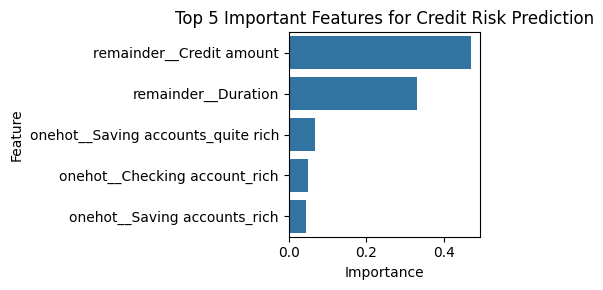

In [145]:
# Get feature importances
importances = best_rf.feature_importances_

# Recall: we used ColumnTransformer and OneHotEncoder earlier,
# so we need correct feature names
feature_names = ct.get_feature_names_out()

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 15 important features
plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(5))
plt.title('Top 5 Important Features for Credit Risk Prediction')
plt.tight_layout()
plt.show()

### 6. Building a Final Machine Learning Pipeline

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Preprocessing steps
# - Impute missing values (in case new data has missing Saving/Checking accounts)
# - Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot', OneHotEncoder(drop='first'))
    ]), categorical_cols)
], remainder='passthrough')

# 2. Full Pipeline: preprocessing + best Random Forest model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_rf)  # you can replace best_rf with best_dt if you prefer Decision Tree
])

# 3. Train the full pipeline
final_pipeline.fit(X, y)

print("✅ Final pipeline created and trained successfully!")

✅ Final pipeline created and trained successfully!


Predicting new applicant

In [147]:
new_applicant = pd.DataFrame({
    'Age': [35],
    'Sex': ['male'],
    'Job': [2],
    'Housing': ['own'],
    'Saving accounts': ['little'],
    'Checking account': ['moderate'],
    'Credit amount': [5000],
    'Duration': [24],
    'Purpose': ['car']
})

# Predict credit risk (0 = Low Risk, 1 = High Risk)
prediction = final_pipeline.predict(new_applicant)
print("Prediction (0=Low Risk, 1=High Risk):", prediction[0])

Prediction (0=Low Risk, 1=High Risk): 1


### 7. Saving the model

In [148]:
import joblib
# Save the model
joblib.dump(best_rf, 'credit_risk_model.pkl')
print("✅ Model saved as credit_risk_model.pkl")

# Save the ColumnTransformer (instead of label encoders)
joblib.dump(ct, 'column_transformer.pkl')
print("✅ ColumnTransformer saved as column_transformer.pkl")

✅ Model saved as credit_risk_model.pkl
✅ ColumnTransformer saved as column_transformer.pkl


### 8. Key Insights

1.	Credit Amount 
   •The larger the requested credit amount, the higher the risk.
   •Applicants requesting higher loans are more likely to be classified as high credit risk.
2.	Duration
   •Longer loan durations are associated with higher risk.
   •Shorter repayment periods tend to indicate lower risk.
3.	Checking Account Status
   •Applicants with no or low funds in checking accounts were at a much higher risk.
   •Having a "good" or "rich" checking account balance correlates with better creditworthiness.
4.	Savings Account
   •A healthier savings account is a strong positive indicator for loan repayment.
5.	Purpose of Loan
   •Certain loan purposes like education, business startup, and repairs had slightly higher risk compared to loans for car purchases or furniture.
6.	Employment and Age
   •Applicants with longer employment durations and slightly older applicants were generally lower risk.



### 9. Recommendations to Improve Credit Evaluation Process

1.	Tighten loan approval thresholds for applicants with high credit amount and long durations unless strong financials are shown.
2.	Prioritize applicants with:
•	Good savings and checking account balances
•	Stable employment history
3.	Enhance customer profiling:
•	Deep-dive into the loan purpose — loans for risky ventures should undergo stricter verification.
4.	Dynamic credit limits:
•	Offer lower initial limits for high-risk applicants with a potential to increase based on repayment behavior.
5.	Automate pre-screening:
•	Use simple machine learning models to automatically flag high-risk applicants based on top features like Credit Amount, Duration, and Checking Account.
